# Quantum Counting

Natalie Chung and Rafael I. Nepomechie

In [1]:
# Import libraries
from qiskit import *
import qiskit
import math
from qiskit.circuit.library import QFT
from qiskit import Aer
from qiskit.visualization import plot_histogram

In [2]:
# Defining the "diffuser" W, 
# which acts on n qubits ("input" register for Grover search)
# qc is a quantum circuit
# q is a quantum register
# Note that we actually implement -W !
#
def W(qc,q):
    qc.h(q[0:n])
    qc.x(q[0:n])
    
    # We implement control Z using CNOT and H's
    qc.h(q[n-1])
    qc.mct(list(range(0,n-1)),q[n-1])
    qc.h(q[n-1])
       
    qc.x(q[0:n])
    qc.h(q[0:n])    

In [3]:
# Defining the standard protocal Uf for a single marked element (a),
# which acts on n+1 qubits ("input" + "output" registers for Grover search)
# a is the marked element, which is an n-bit integer string
#
def Uf(qc,q,a):
    for i in range(n):
        if a[i]=='0':
            qc.x(q[n-1-i])
            
    qc.mct(list(range(0,n)),q[n])
    
    for i in range(n):
        if a[i]=='0':
            qc.x(q[n-1-i])

In [4]:
# Defining the standard protocol Uff for multiple marked elements
# as a product of Uf's
# num is a list of the marked elements
#
def Uff(qc, q, num):    
    for i in num:
        Uf(qc,q,i)
        

In [5]:
# Control gate for the Grover operator
#
def cu(power):
    q=QuantumRegister(n+1)
    qc = QuantumCircuit(q)
        
    # Constructing the Grover operator gate to 2**power
    for i in range(2**power):
        Uff(qc,q,num)
        W(qc,q)
                
    c_q = qc.to_gate().control()
    
    return c_q

## Example: n = 3, m=3, t=5

In [6]:
# Number of qubits used in the "input" register for Grover search
n = 3
# Marked elements (list of n-bit integer strings); note that here there are 3 such elements
num = ['010','100', '110']
# Number of ancillary qubits for QPE:
t = 5 

We pretend that we don't know the number $m$ of marked elements.

We proceed to use Quantum Counting to determine $m$

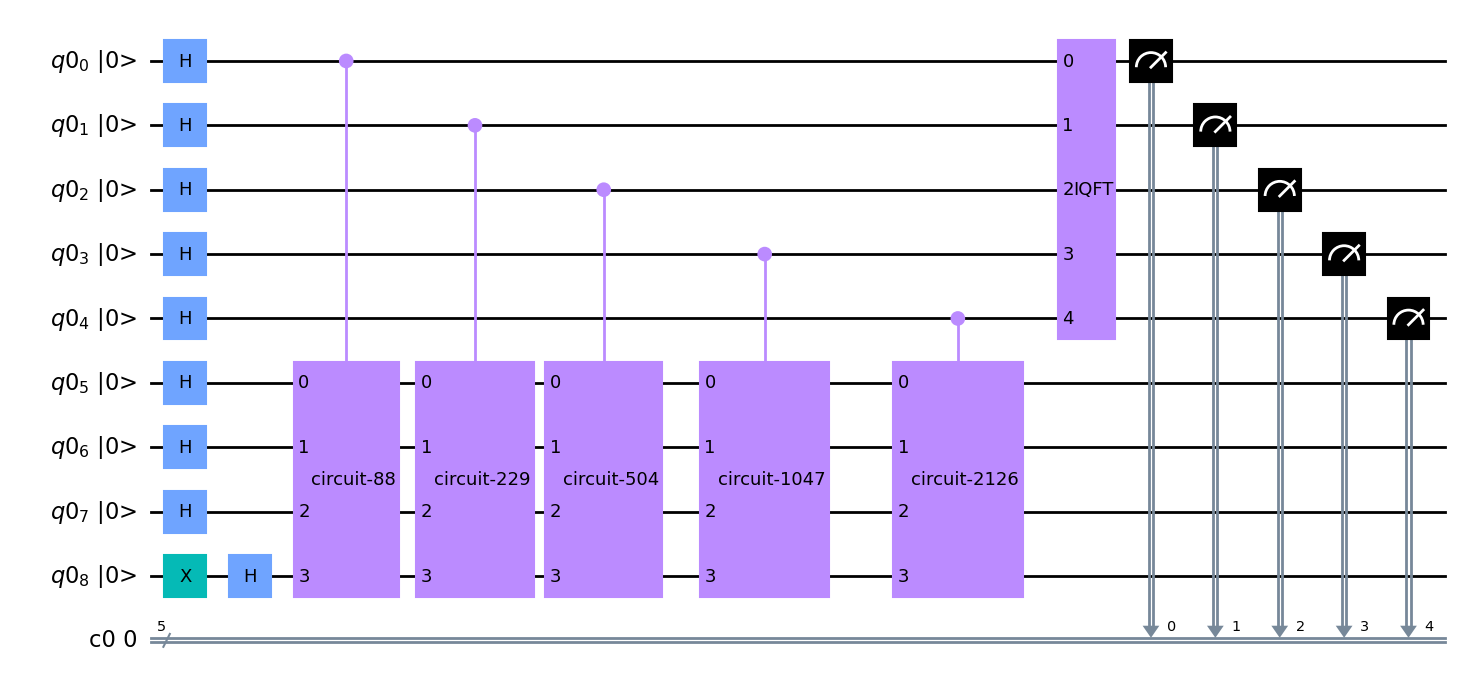

In [7]:
# Quantum Counting

q=QuantumRegister(t+n+1)
creg = ClassicalRegister(t)
qc = QuantumCircuit(q,creg)

# Initialize the ancillay qubits for QPE
qc.h(q[0:t])

# Setting up the vector for QPE: 

# Initialize the "input" register for Grover search
qc.h(q[t:t+n])

# Initialize the "output" register for Grover search
qc.x(q[t+n])
qc.h(q[t+n])
  
# Apply the controlled Grover rotations on the "input" and "output" registers
for i in range(t):
    index_list = [i]
    index_list+=list(range(t,q.size))
    qc.append(cu(i),index_list)
          
# Apply the inverse quantum Fourier transform on the ancillary qubits
qc.append(QFT(t).inverse(), q[0:t])

# Measure the ancillary qubits          
qc.measure(q[0:t],creg)

qc.draw(output="mpl", initial_state=True)

In [8]:
# Simulation
simulator = Aer.get_backend("qasm_simulator")

In [9]:
job = execute(qc, backend=simulator, shots = 1024)
result = job.result()
counts1 = result.get_counts(qc)
print(counts1)
# Get the most frequent value from counts1, which is the integer j that QPE returns
freq = qiskit.result.Counts.most_frequent(counts1)
j = int(freq,2)
print(j)

{'00010': 1, '10010': 3, '00100': 1, '01100': 3, '10101': 4, '00101': 4, '10111': 379, '01101': 2, '01111': 2, '10000': 2, '11001': 6, '10011': 1, '01110': 3, '10100': 10, '00111': 4, '01011': 13, '00001': 1, '11010': 4, '00000': 1, '11000': 11, '11011': 2, '01001': 417, '00110': 2, '10110': 56, '01010': 68, '01000': 24}
9


Since we actually implemented $-W$, the number of marked elements $m$ is given by the integer closest to
$$ 2^n \sin^2\left[ \pi\left(\frac{j}{2^t} - \frac{1}{2}\right)\right]\,, $$\
see the final equation of our paper.


In [10]:
# Number of marked elements!
m = round(2**(n)*(math.sin(math.pi*(j/(2**t))-math.pi/2)**2))
print (m)

3


We see that this result for $m$ from Quantum Counting indeed matches with the actual number of marked elements:

In [11]:
len(num)

3

### Grover search

Having used Quantum Counting to determine the number $m$ of marked elements, we can now proceed to search for these elements using Grover.

The required number $k$ of Grover iterations is the integer closest to

$$\frac{\pi}{4}\sqrt\frac{2^n}{m}$$

In [12]:
# Number of Grover iterations
k = round(math.pi/4*math.sqrt(2**(n)/m))
print(k)

1


In [13]:
# Grover search!
qreg1=QuantumRegister(n+1)
creg1 = ClassicalRegister(n)
qcircuit = QuantumCircuit(qreg1,creg1)

# Initialize the "input" register
qcircuit.h(qreg1[0:n])

# Initialize the "output" register
qcircuit.x(qreg1[n])
qcircuit.h(qreg1[n])

qcircuit.barrier()

# Grover iterations
for i in range(k):
    Uff(qcircuit, qreg1, num)
    qcircuit.barrier()
    W(qcircuit, qreg1)
    qcircuit.barrier()
    
qcircuit.measure(qreg1[0:n],creg1)

qcircuit.draw(output="mpl", initial_state=True)

{'101': 37, '110': 285, '100': 288, '001': 27, '011': 35, '111': 42, '000': 19, '010': 291}


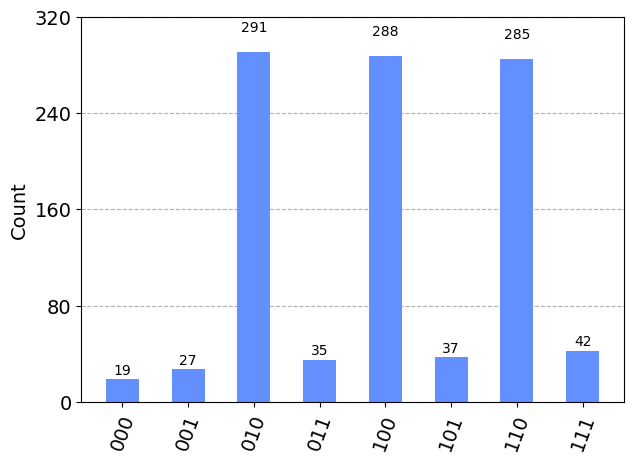

In [14]:
job = execute(qcircuit, backend=simulator, shots = 1024)
result = job.result()
counts = result.get_counts(qcircuit)
print(counts)
plot_histogram(counts)

We see from the histogram that indeed 3 integers occur with high probabilities; and these integers indeed match with the actual marked elements:

In [15]:
print(num)

['010', '100', '110']
